## 1. Installing required libraries

We have lots of data related to market movements of US indexes. US indexes are one of the most famous instruments for investing and trading because of the high volume there. 

In this document, we will predict Dow Jones movements using XGboost. 
We have data for 10 years started in 2009. First 8 years will be used for training the model and the last 2 for testing. 
In this document, we use only Close price at the end of each day of the market movements. 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 15
import warnings
warnings.filterwarnings("ignore")

## 2. Loading data and preprocessing data

The DataSet is not good for the analyze and study the model because there are "." in come cells. Those values should be interpolated. 

In [70]:
data = pd.read_csv('DJIA.csv', na_values = ['.'], index_col='DATE', parse_dates = ['DATE'])
data['DJIA'] = data['DJIA'].interpolate()
print(data.head())

               DJIA
DATE               
2009-07-23  9069.29
2009-07-24  9093.24
2009-07-27  9108.51
2009-07-28  9096.72
2009-07-29  9070.72


In [71]:
data.index

DatetimeIndex(['2009-07-23', '2009-07-24', '2009-07-27', '2009-07-28',
               '2009-07-29', '2009-07-30', '2009-07-31', '2009-08-03',
               '2009-08-04', '2009-08-05',
               ...
               '2019-07-09', '2019-07-10', '2019-07-11', '2019-07-12',
               '2019-07-15', '2019-07-16', '2019-07-17', '2019-07-18',
               '2019-07-19', '2019-07-22'],
              dtype='datetime64[ns]', name='DATE', length=2608, freq=None)

In [72]:
ts = data['DJIA']

In [73]:
ts.head()

DATE
2009-07-23    9069.29
2009-07-24    9093.24
2009-07-27    9108.51
2009-07-28    9096.72
2009-07-29    9070.72
Name: DJIA, dtype: float64

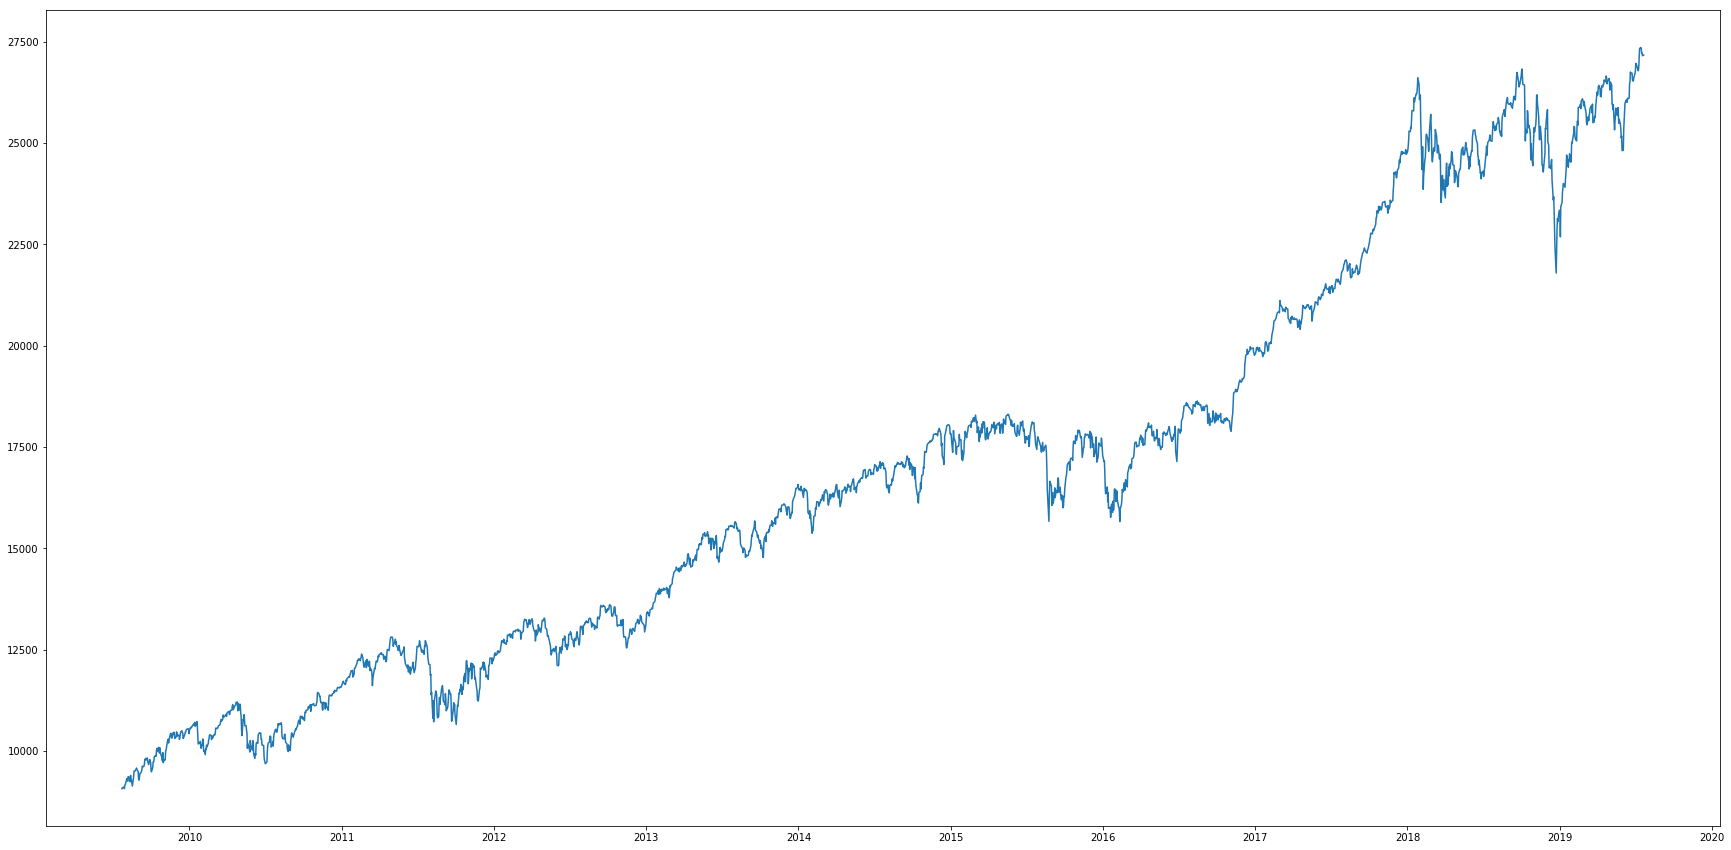

In [74]:
plt.plot(ts)

We see a strong up trend in the Dow Jones movements 

## 3. Checking Stationary

According to ARIMA the Chart should be stationaty to use the method 

### 3.1. Function to define stationary based on the Dickey-Fuller test

According to the model, the set is stationary, when Test Statistic < Critical Value.
We use 200 rolling to check it, because 200 moving averages are an important indicator of the trend and used by traders and investors

In [75]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(200).mean()
    rolstd = timeseries.rolling(200).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

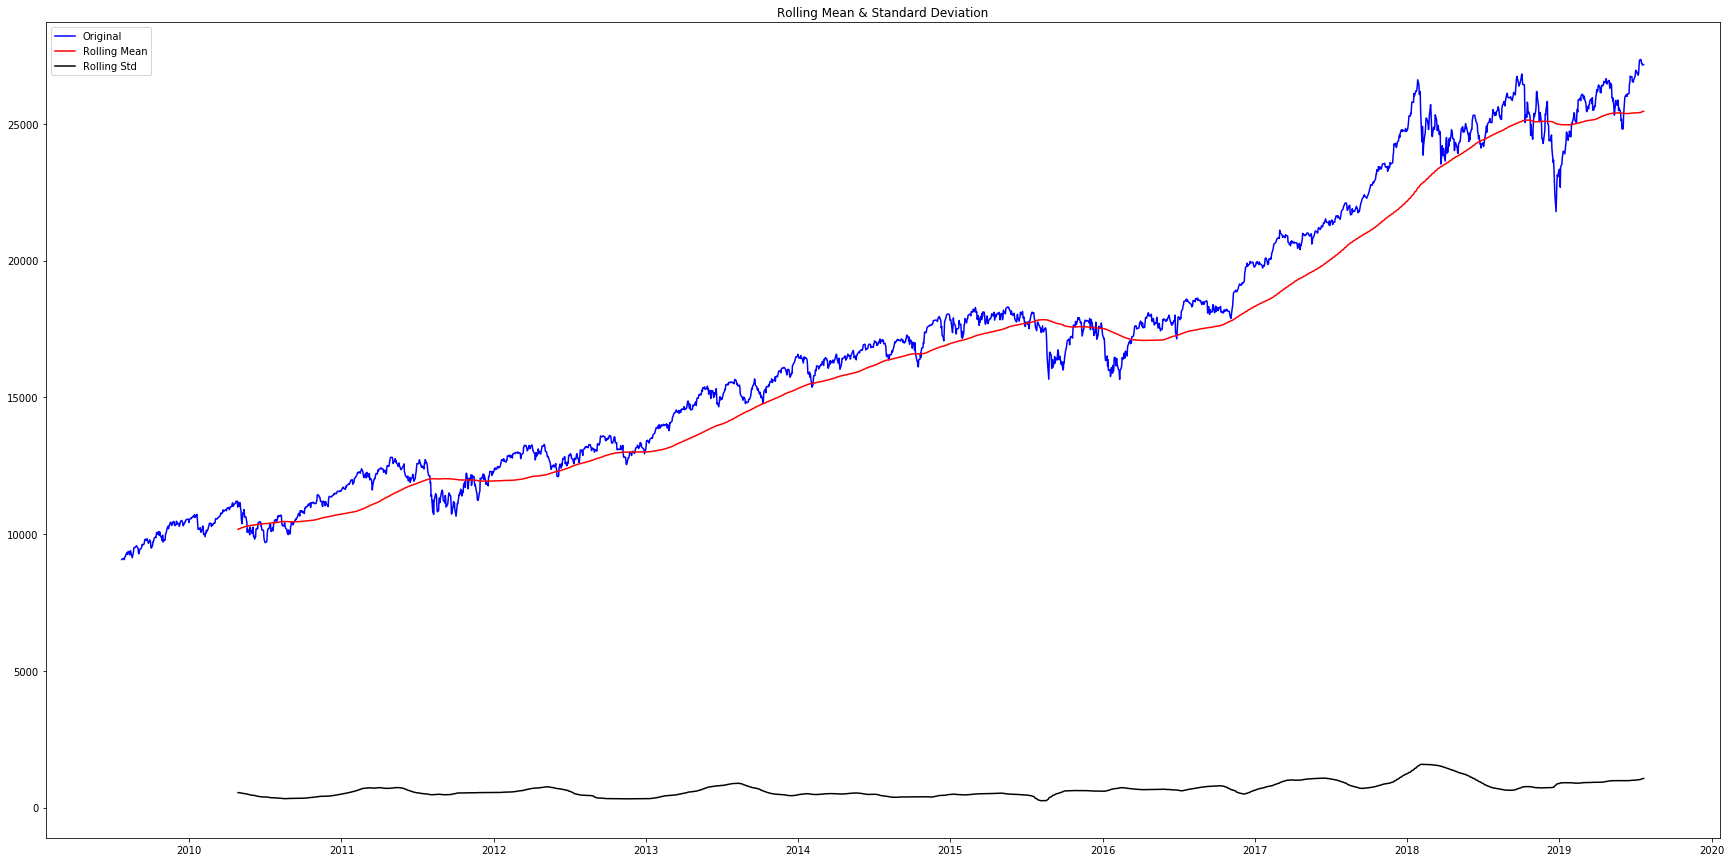

Results of Dickey-Fuller Test:
Test Statistic                    0.004586
p-value                           0.958910
#Lags Used                        5.000000
Number of Observations Used    2602.000000
Critical Value (1%)              -3.432866
Critical Value (5%)              -2.862651
Critical Value (10%)             -2.567362
dtype: float64


In [76]:
test_stationarity(ts)

Though the variation in standard deviation is small, the mean is clearly increasing with time and Test Static > Critical Value (10% ). This is not a stationary series. 

## 4. Make Time Series Stationary 

There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the Volume and Price changes over time.
2. Seasonality – variations at specific time-frames. On July and August, the US market is too flatty, On September - too fast and sharp.

### 4.1. Estimating & Eliminating Trend

##### Smoothing (Moving Avarages)

Lets apply transformation which penalize higher values more than smaller values. Take a log transform here.

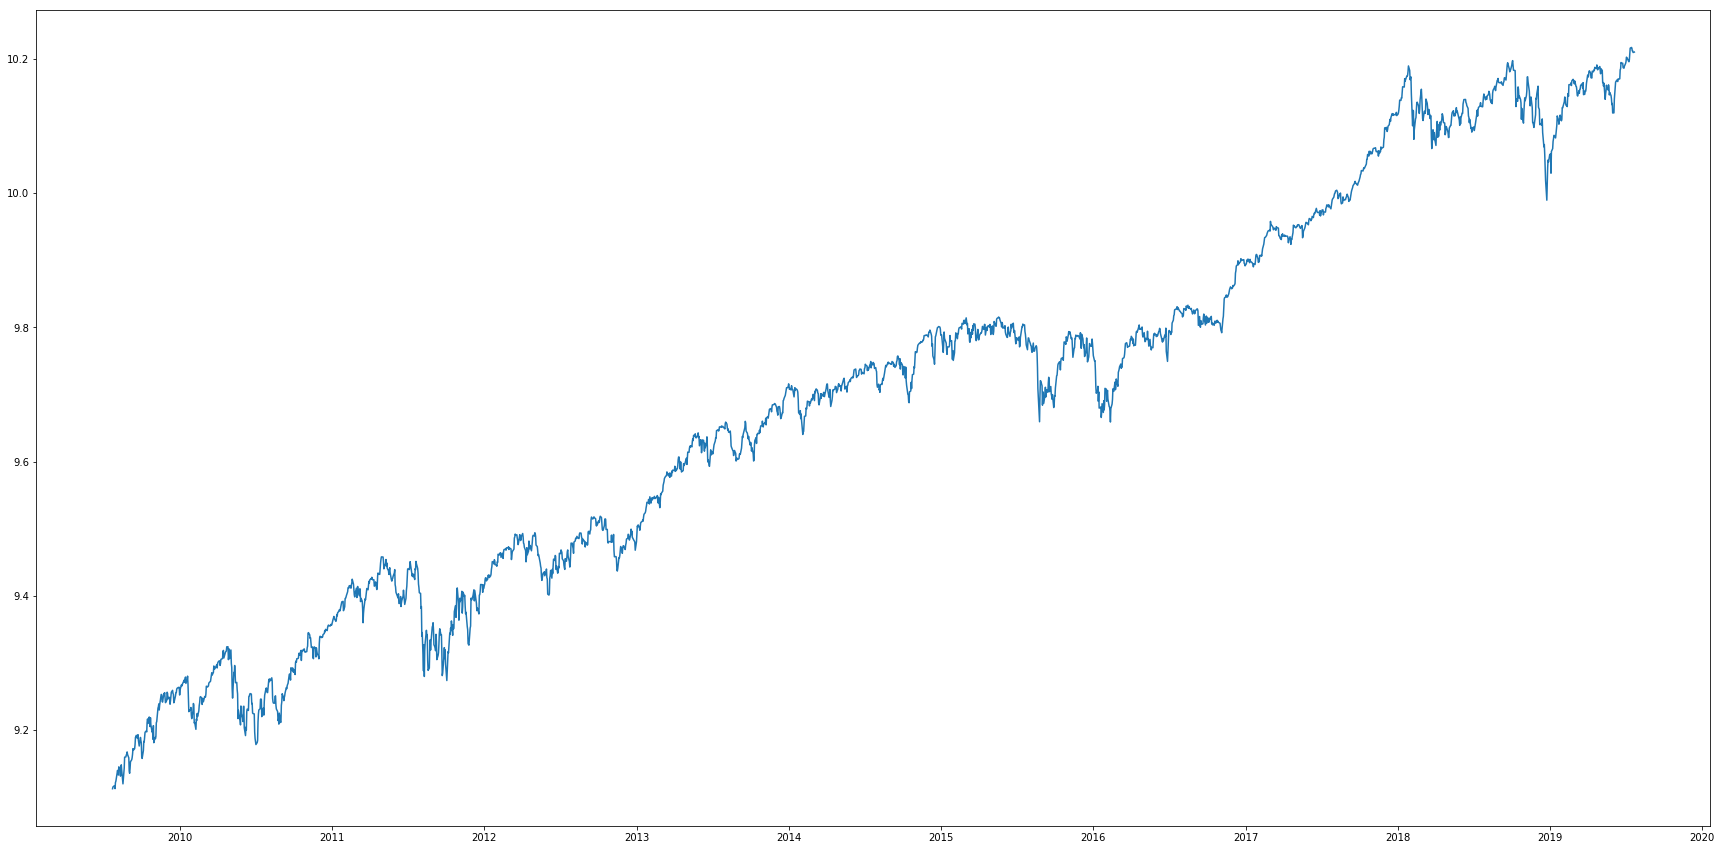

In [77]:
ts_log = np.log(ts)
plt.plot(ts_log)

Use smoothing (Moving Avarage with the period 200)

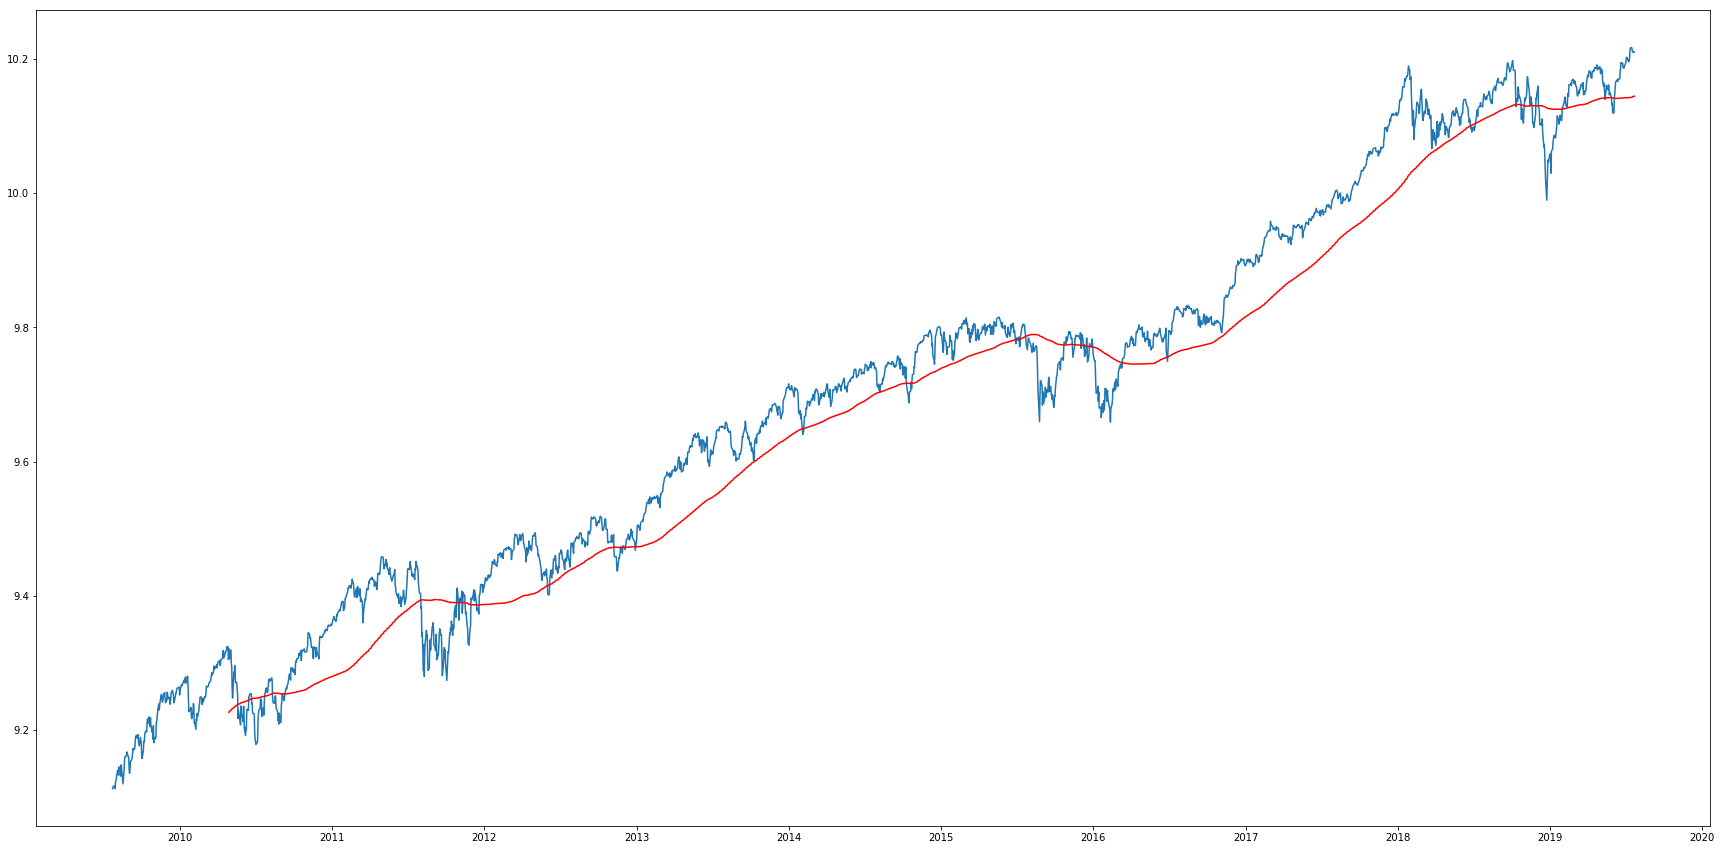

In [78]:
moving_avg = ts_log.rolling(200).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [79]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff[195:203]

DATE
2010-04-22         NaN
2010-04-23         NaN
2010-04-26         NaN
2010-04-27         NaN
2010-04-28    0.083451
2010-04-29    0.093399
2010-04-30    0.078130
2010-05-03    0.090044
Name: DJIA, dtype: float64

In our case, first 200 values are NaN because we do not have enough data for calculation

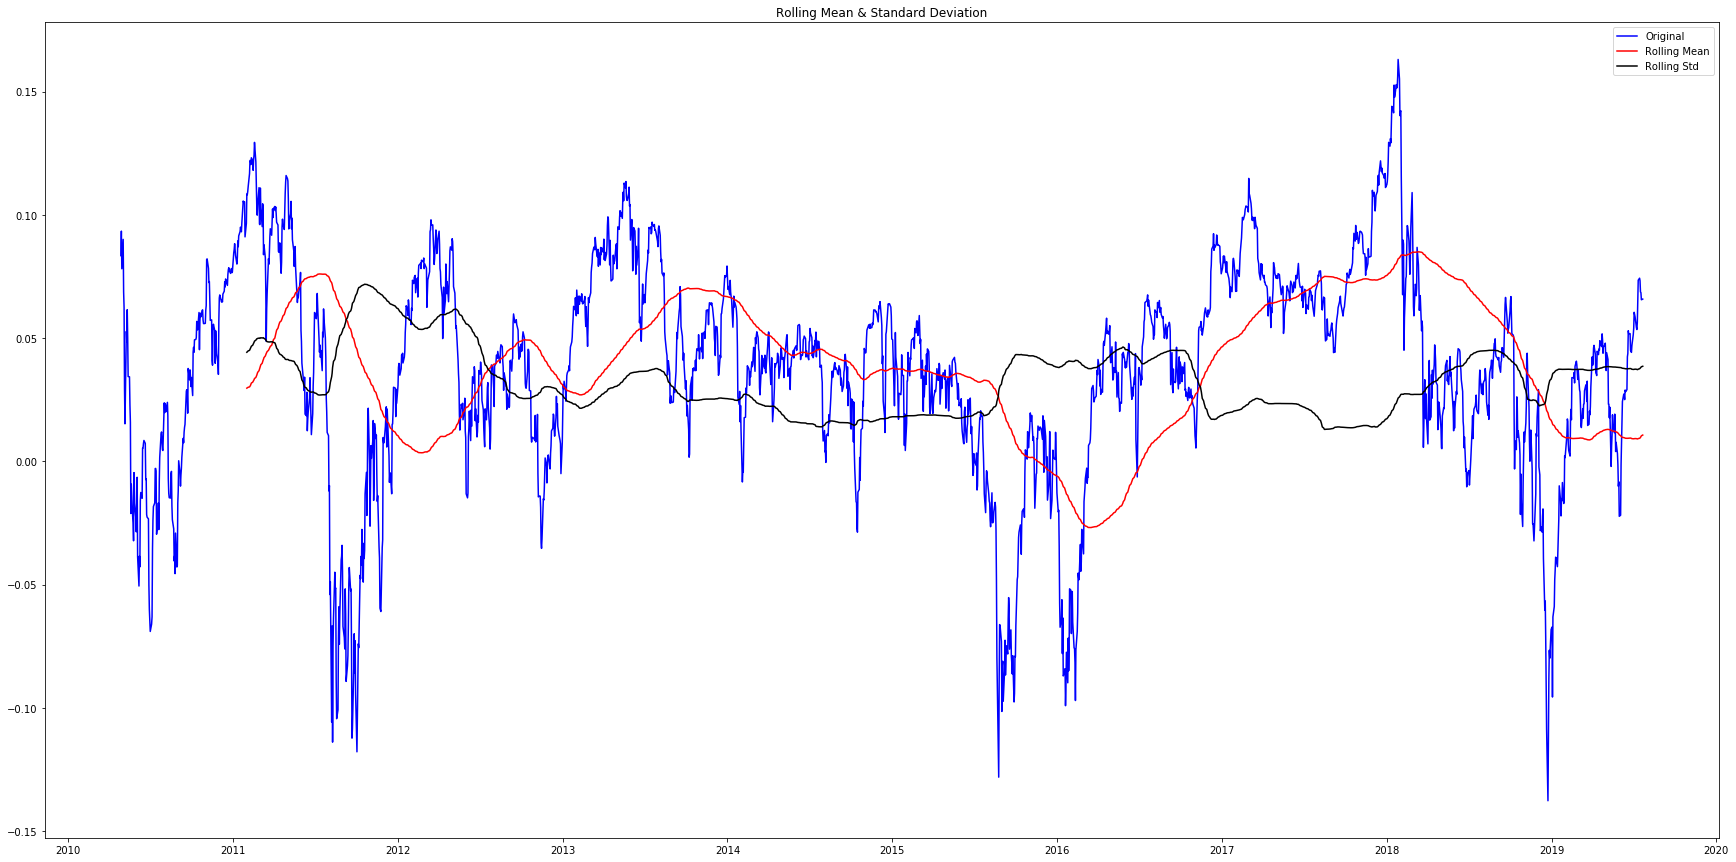

Results of Dickey-Fuller Test:
Test Statistic                   -4.421773
p-value                           0.000272
#Lags Used                        5.000000
Number of Observations Used    2403.000000
Critical Value (1%)              -3.433074
Critical Value (5%)              -2.862744
Critical Value (10%)             -2.567411
dtype: float64


In [80]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series.

Take a ‘weighted moving average’ where more recent values are given a higher weight. Use exponentially weighted moving average

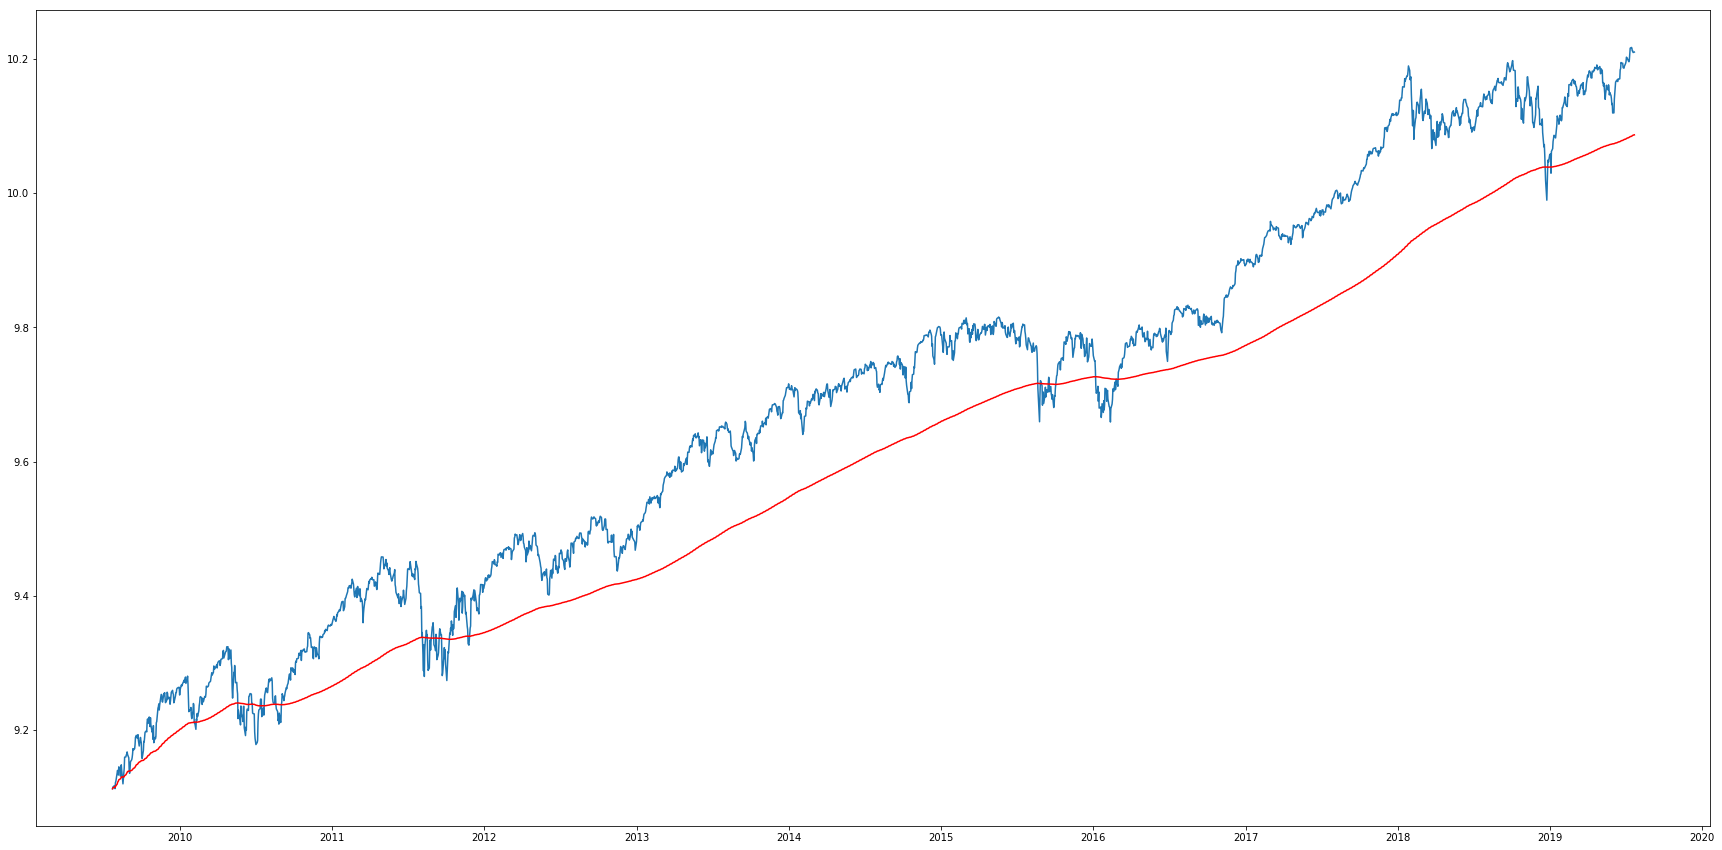

In [81]:
expwighted_avg = ts_log.ewm(halflife=200).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

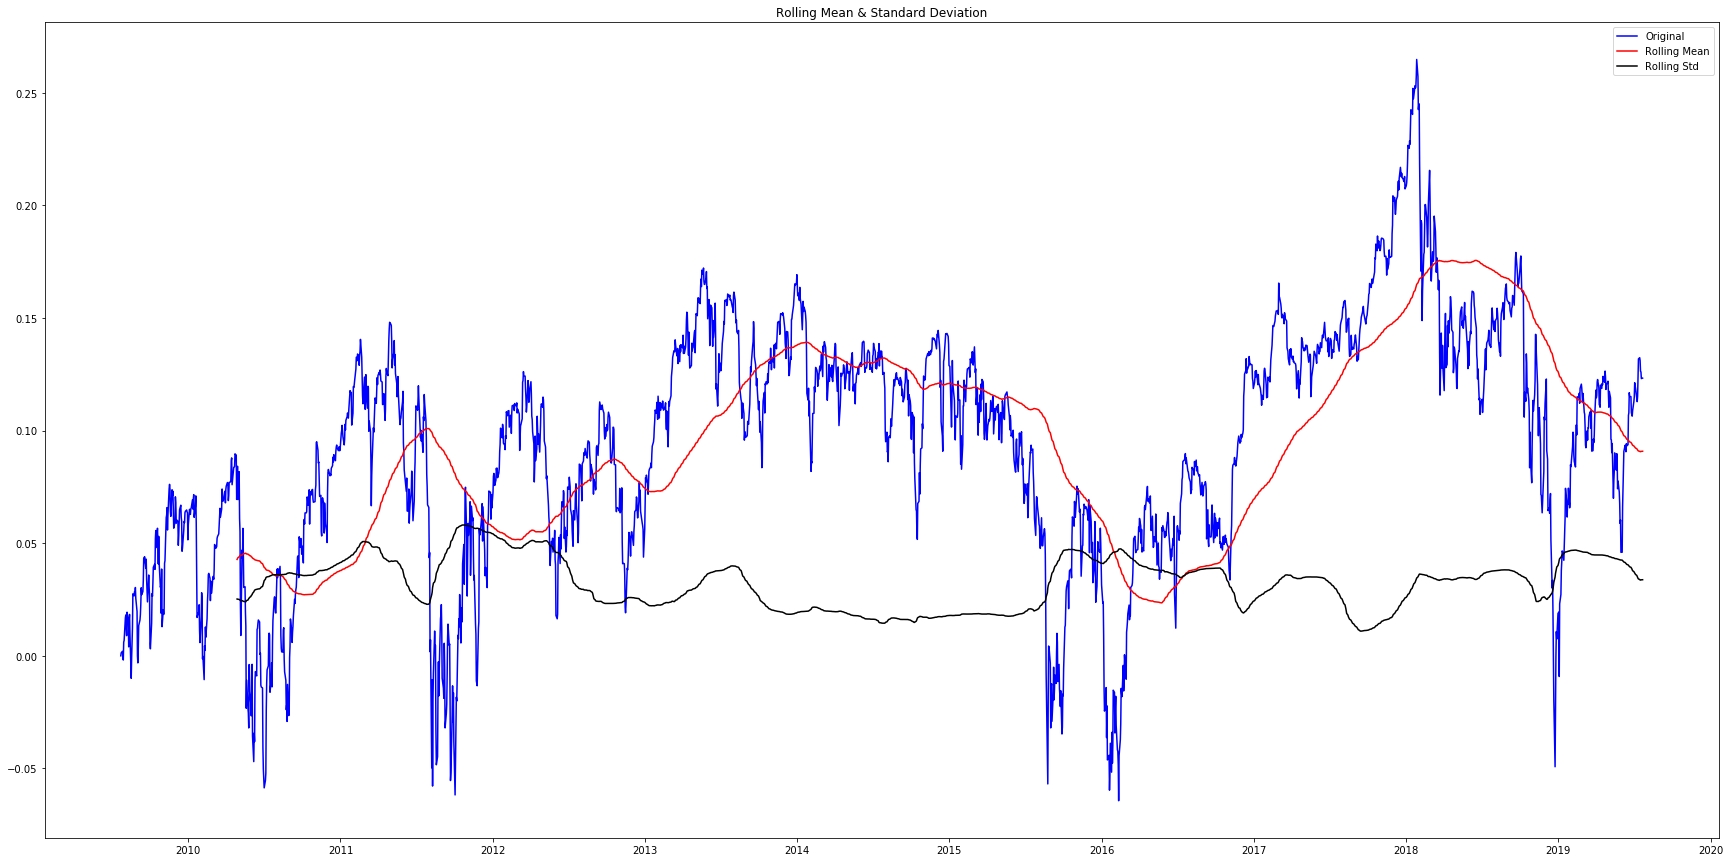

Results of Dickey-Fuller Test:
Test Statistic                   -3.898354
p-value                           0.002047
#Lags Used                        5.000000
Number of Observations Used    2602.000000
Critical Value (1%)              -3.432866
Critical Value (5%)              -2.862651
Critical Value (10%)             -2.567362
dtype: float64


In [82]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, it's a good indicator of stationary 

##### Differencing

Use differencing to make additional transformations

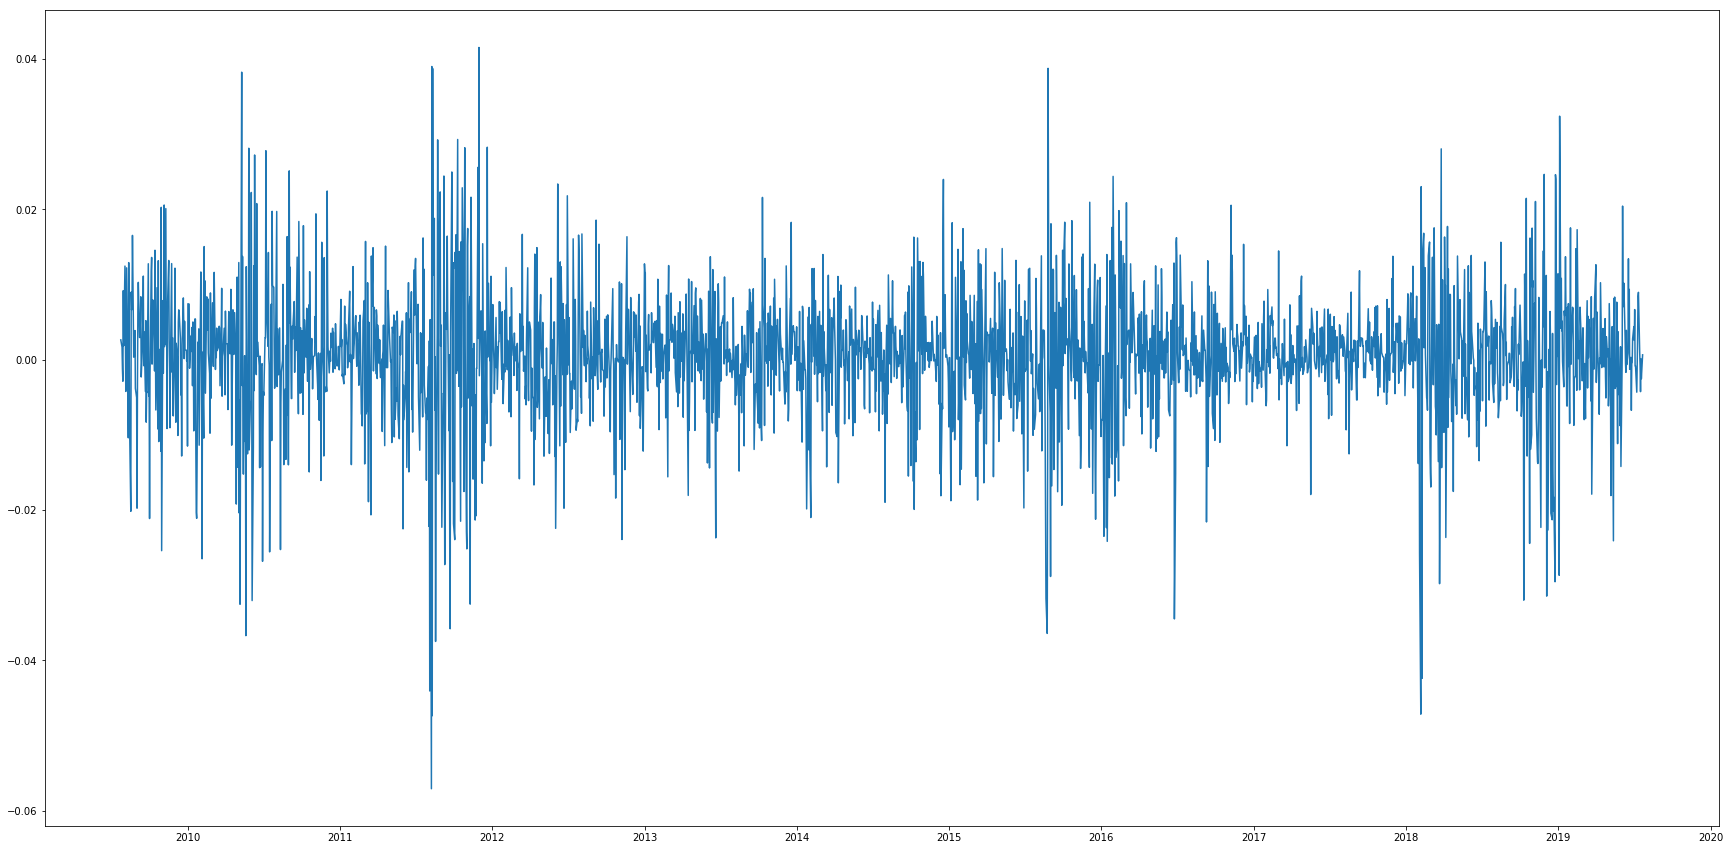

In [83]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

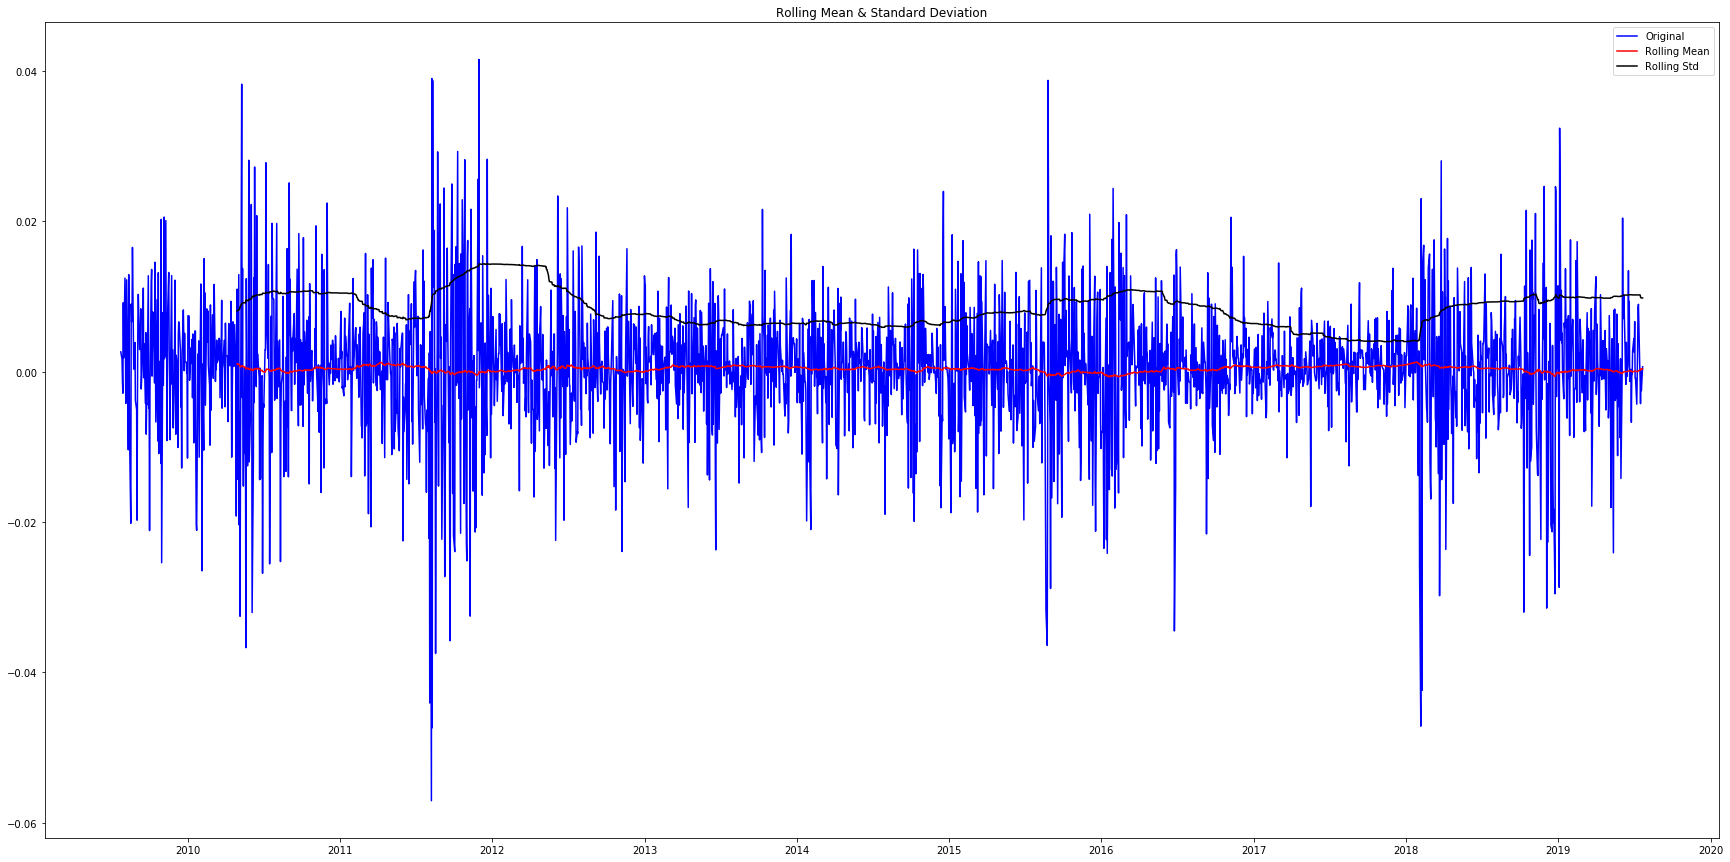

Results of Dickey-Fuller Test:
Test Statistic                  -24.819244
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    2602.000000
Critical Value (1%)              -3.432866
Critical Value (5%)              -2.862651
Critical Value (10%)             -2.567362
dtype: float64


In [84]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We see sgain that the set is stationary. Test Statistic << Critical Value (1%).  

##### Decomposing

Define Seasonality and Residuals for the set

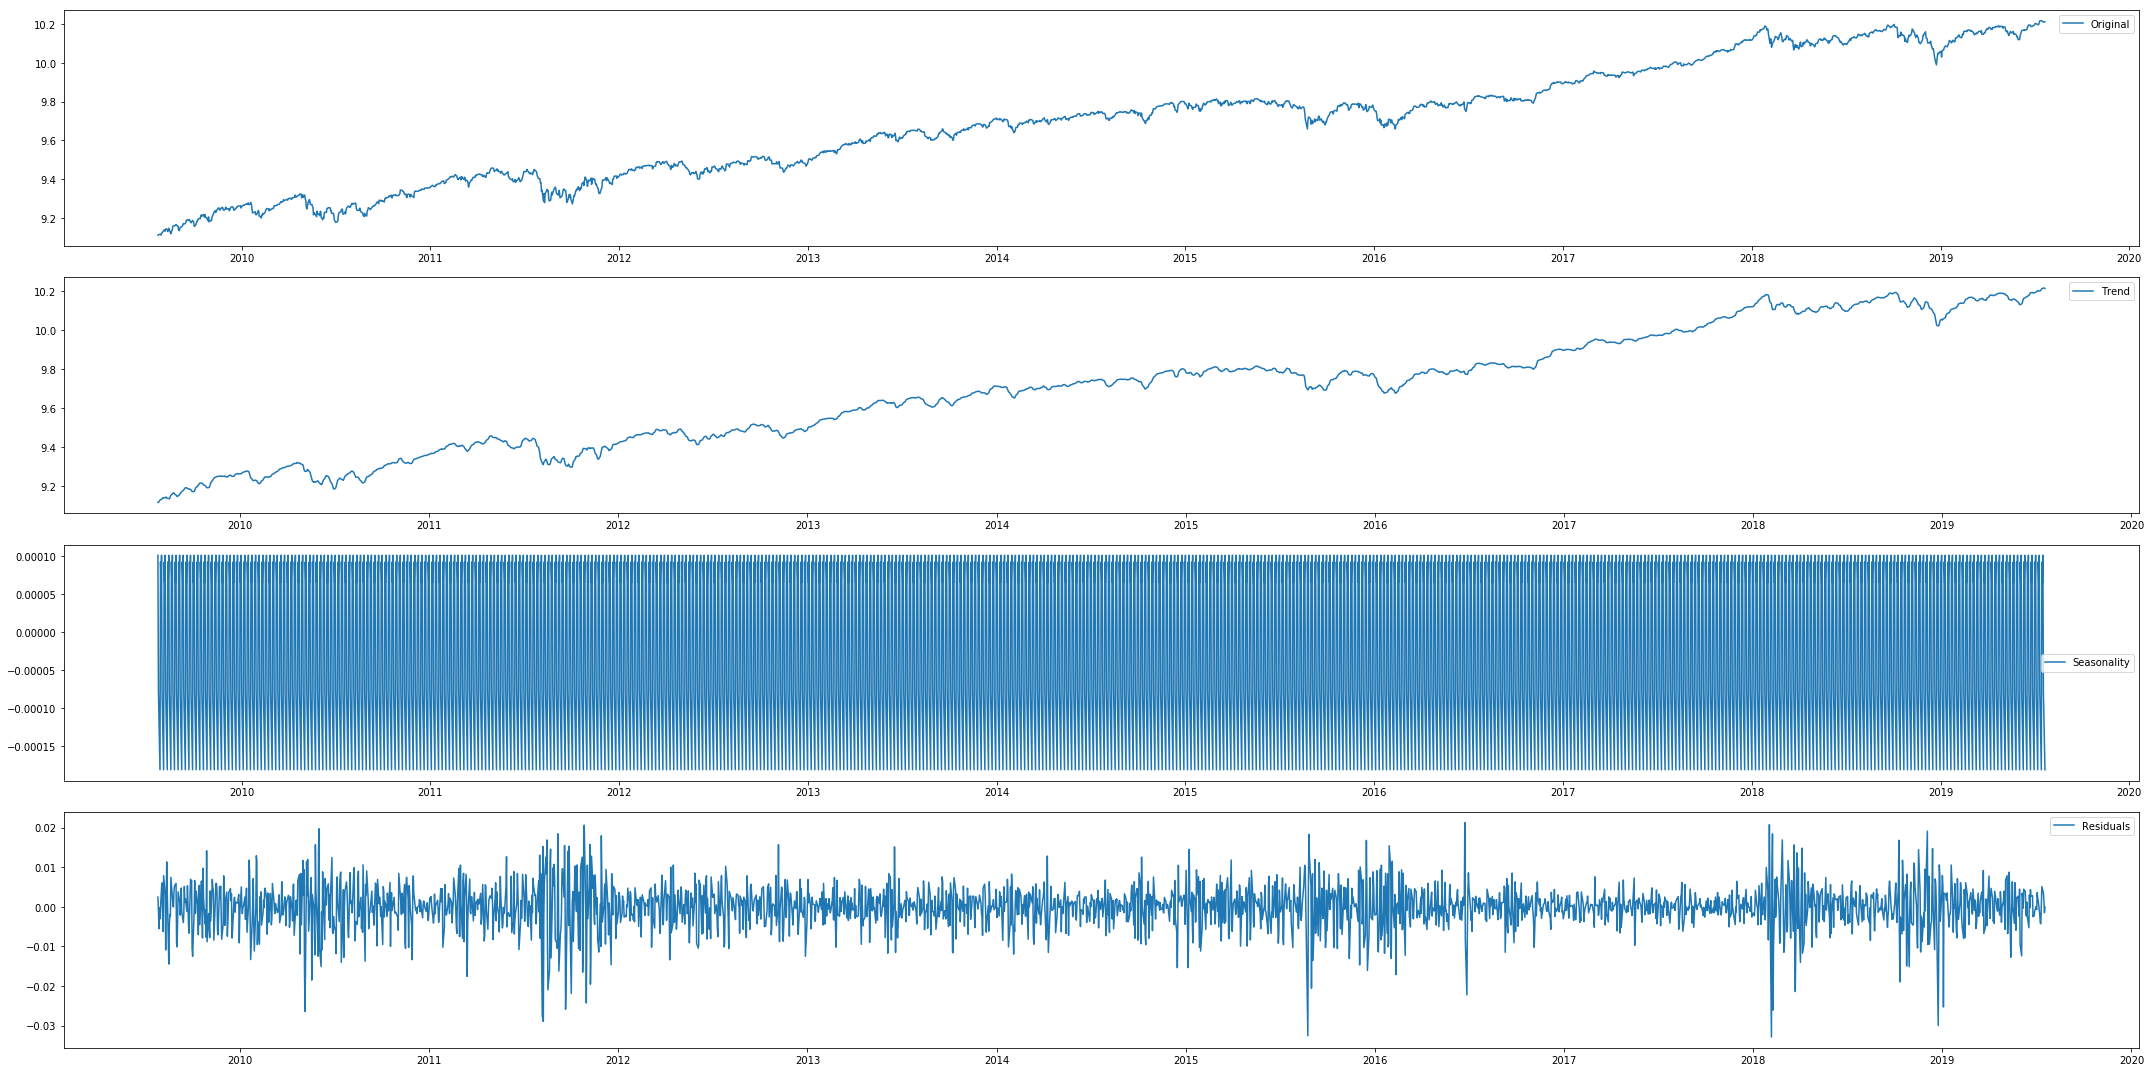

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


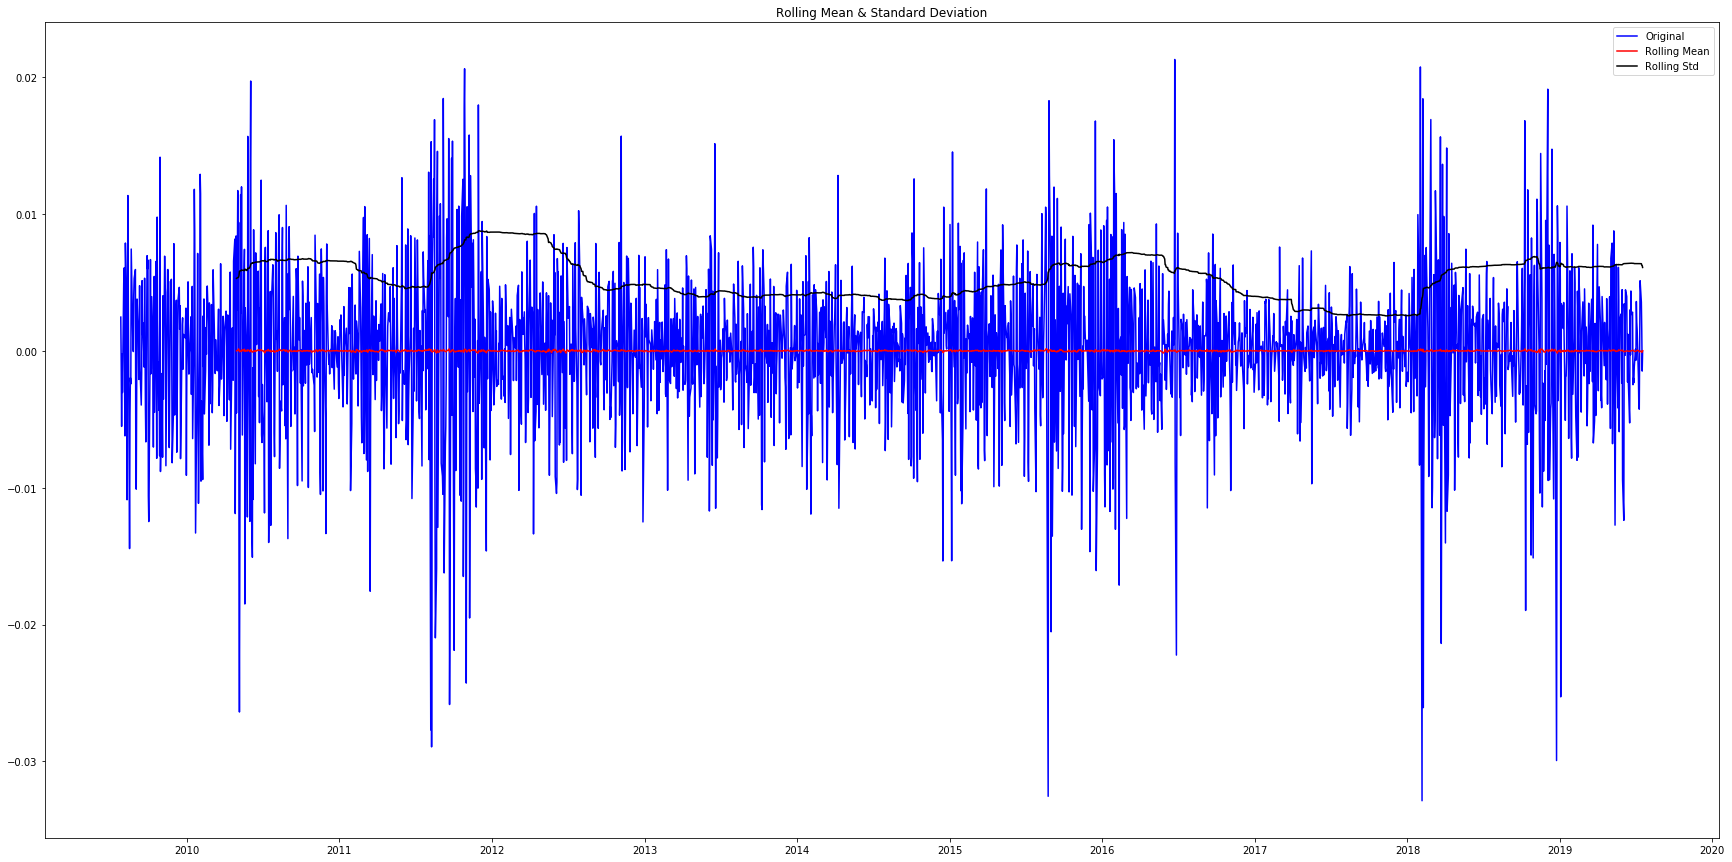

Results of Dickey-Fuller Test:
Test Statistic                -1.615922e+01
p-value                        4.484240e-29
#Lags Used                     2.800000e+01
Number of Observations Used    2.575000e+03
Critical Value (1%)           -3.432892e+00
Critical Value (5%)           -2.862663e+00
Critical Value (10%)          -2.567368e+00
dtype: float64


In [86]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

###### Stationary Summary: All tests tells us that time series are too close to Stationary

## 5. Forecasting a Time Series with ARIMA

### 5.1. Defining 'p' and 'q' paramaters for ARIMA

- p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

We use two plots to determine these numbers.
1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

The ACF and PACF plots for the TS after differencing can be plotted as:

In [87]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [88]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

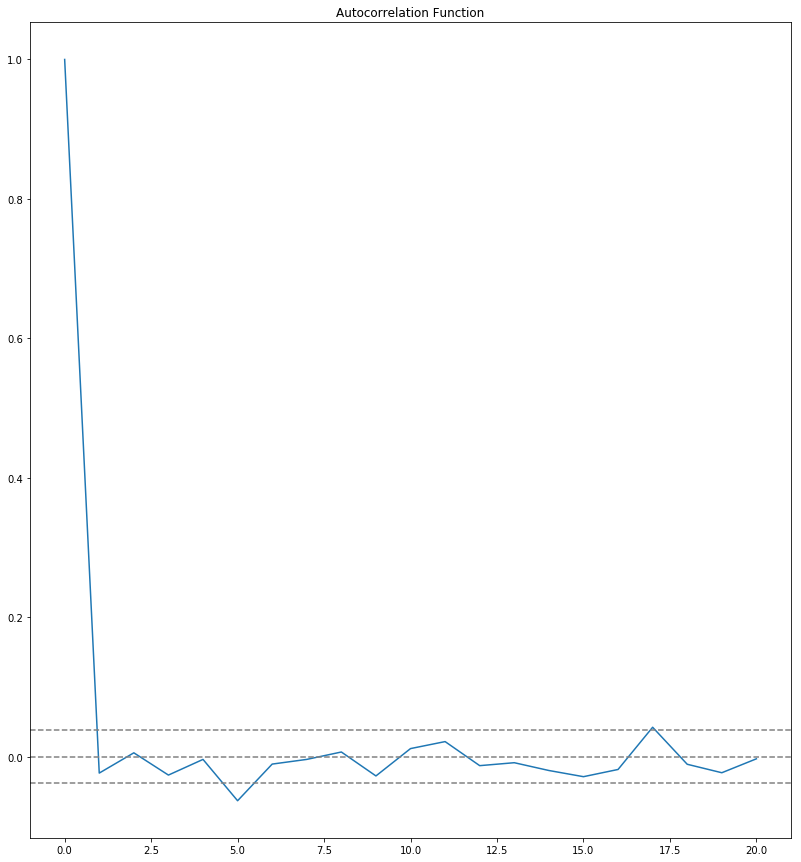

In [89]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

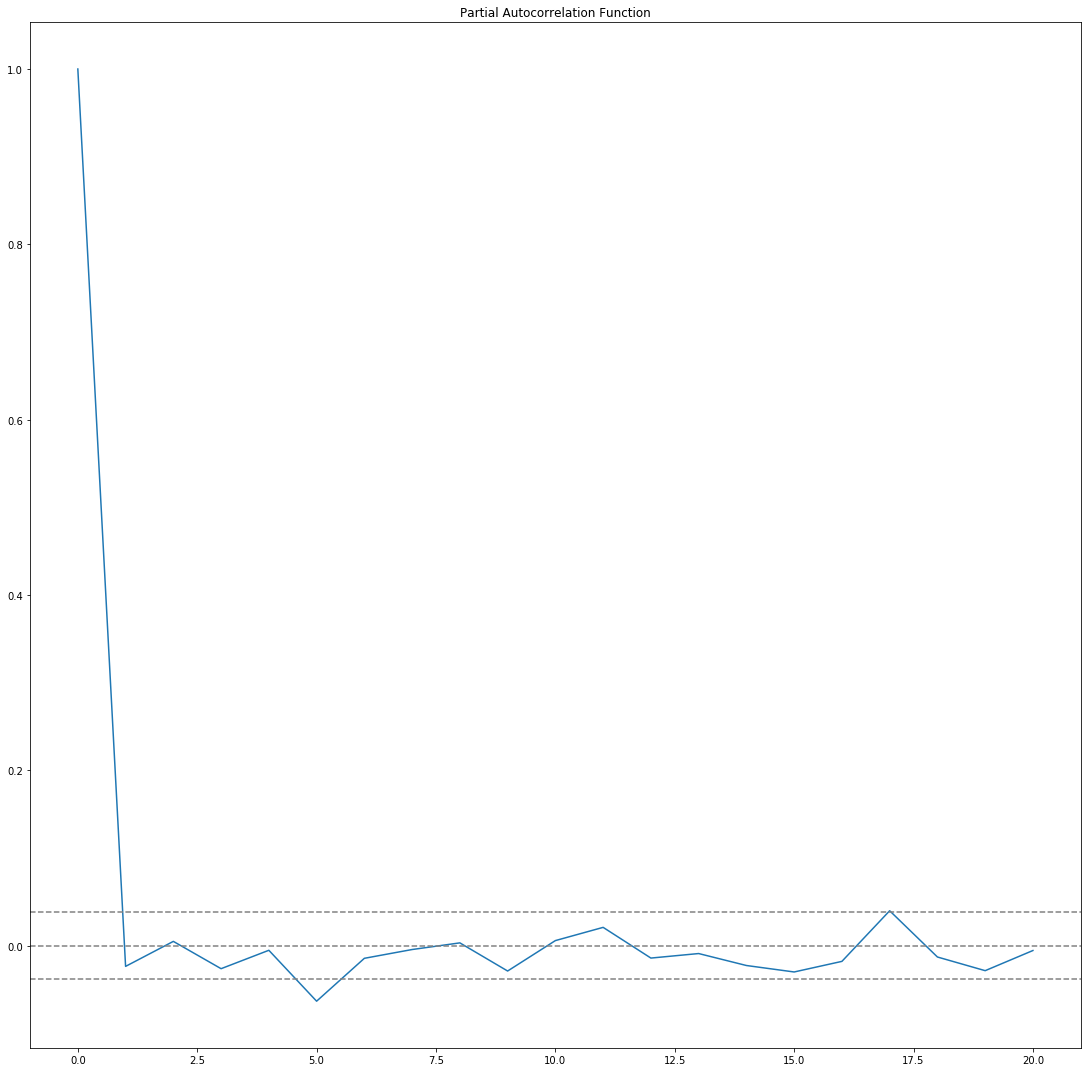

In [90]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:
1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.

Make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

In [91]:
from statsmodels.tsa.arima_model import ARIMA

### 5.2. AR model

Text(0.5, 1.0, 'RSS: 0.1947')

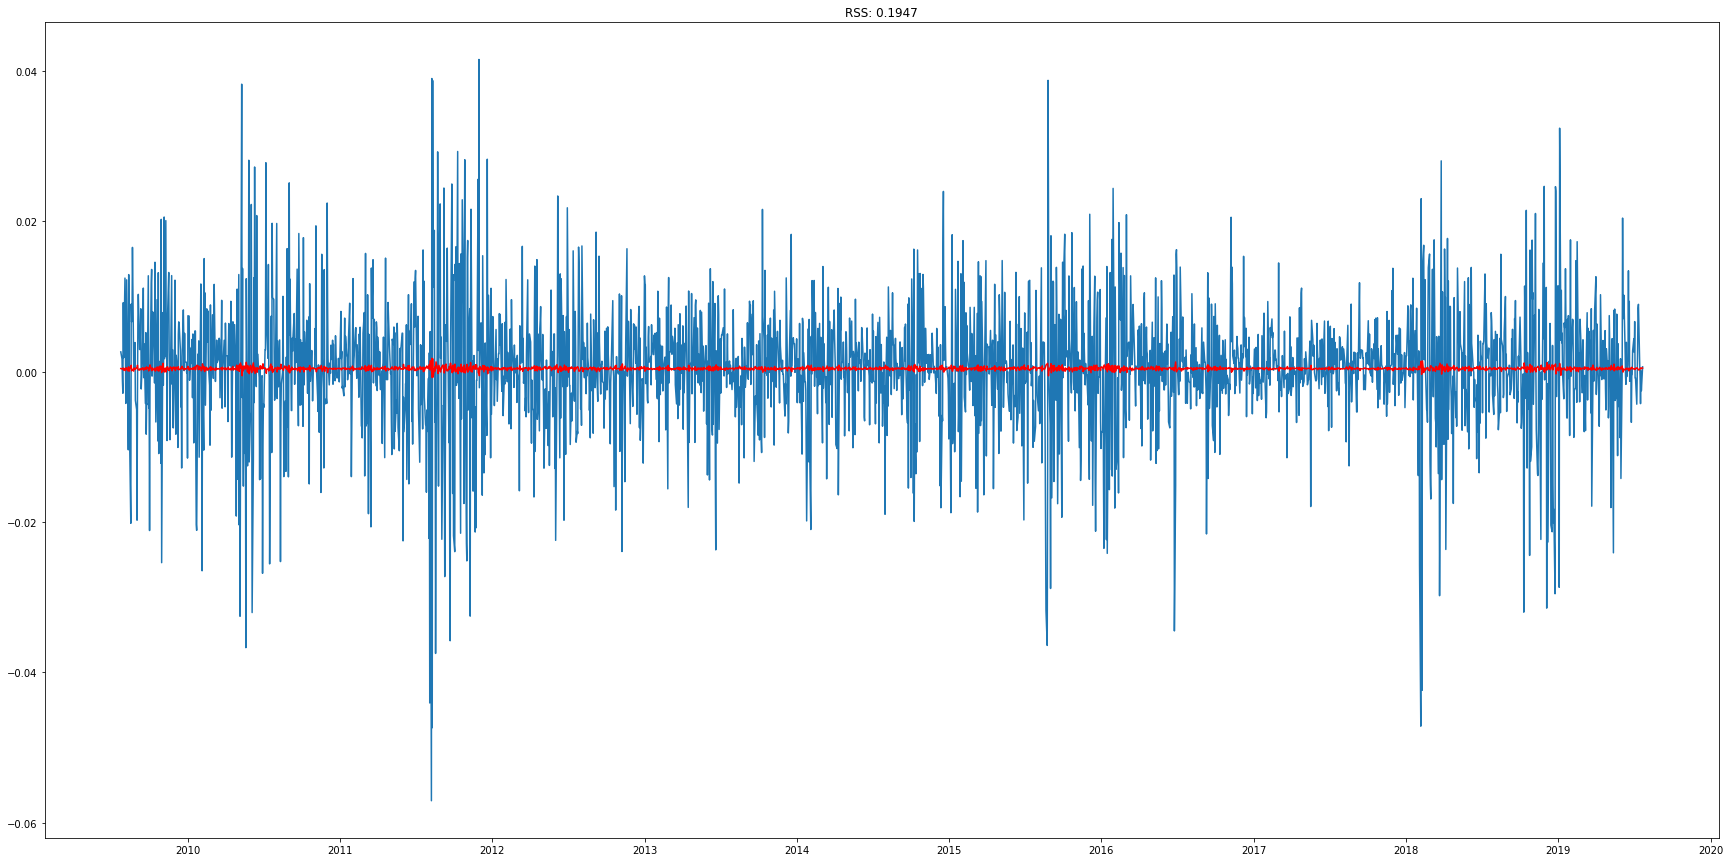

In [92]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### 5.3. MA Model

Text(0.5, 1.0, 'RSS: 0.1947')

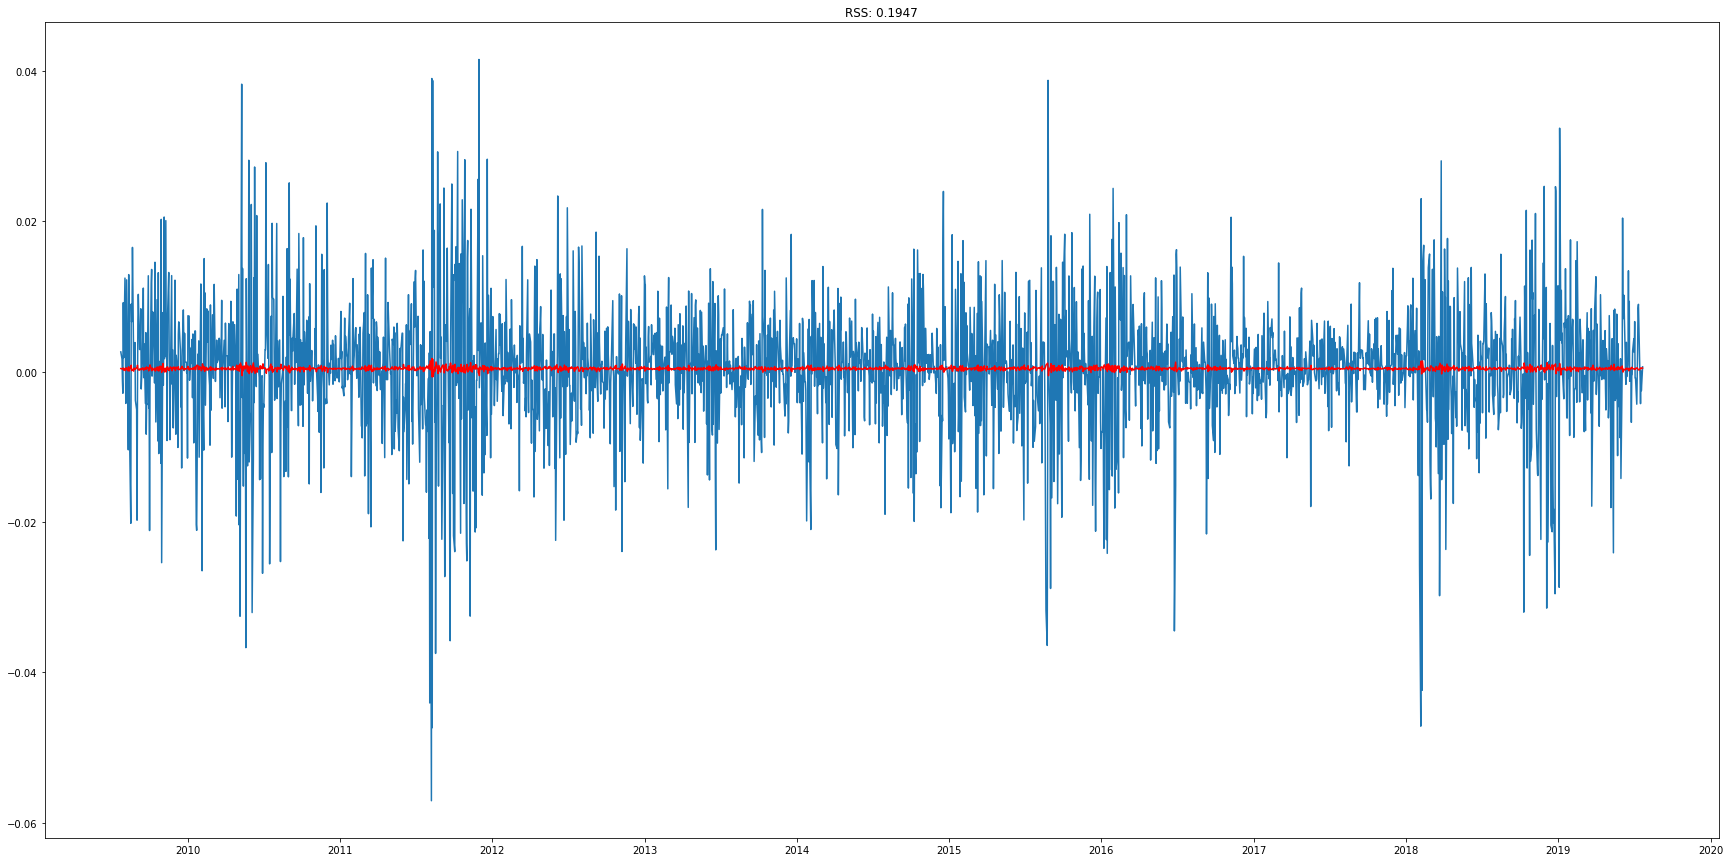

In [93]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Models AR and MA give the same results 

### 5.4.Taking it back to original scale

In [94]:
predictions_ARIMA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

DATE
2009-07-24    0.000421
2009-07-27    0.000369
2009-07-28    0.000400
2009-07-29    0.000466
2009-07-30    0.000490
dtype: float64


Cummulative summ:

In [95]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

DATE
2009-07-24    0.000421
2009-07-27    0.000790
2009-07-28    0.001191
2009-07-29    0.001657
2009-07-30    0.002147
dtype: float64


Series with all values as base number:

In [96]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

DATE
2009-07-23    9.112649
2009-07-24    9.113070
2009-07-27    9.113439
2009-07-28    9.113840
2009-07-29    9.114306
dtype: float64

# 7. Estimate the model

Text(0.5, 1.0, 'RMSE: 1070.5559')

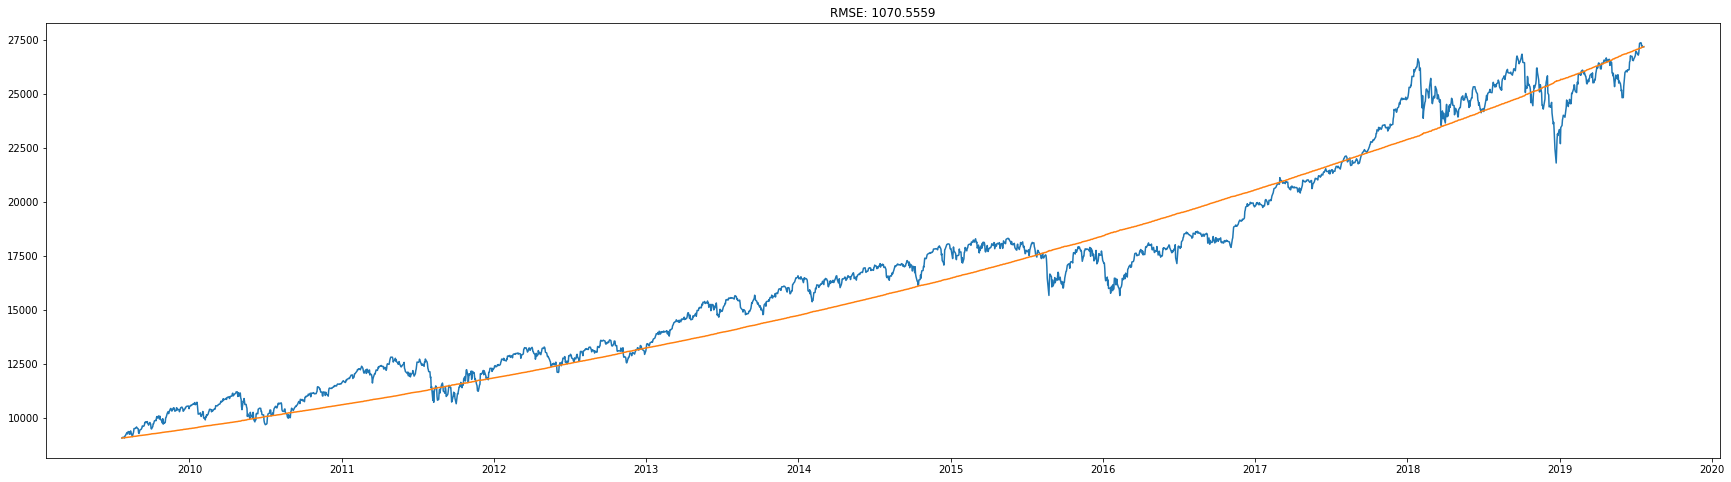

In [104]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
rcParams['figure.figsize'] = 30, 8
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Use another metrics MAPE to estimate the difference between real and predicted values 

In [98]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [99]:
mean_absolute_percentage_error(ts, predictions_ARIMA)

5.5554449068844285

# 8. Conclusion

MAPE is normal. But those model can not be used for prediction in trading. To allow 5.5% trader need to bid stop.
The model can be used only for investing. 